Set subject model.

In [5]:
#must be unique.
model_name = 'Final_Model_1'
epoch_select = 1000

Imports and model init

In [10]:
#imports

import torch
import matplotlib.pyplot as plt
import numpy as np
import time, os, pickle
import pandas as pd


import init
import loader
import visualisation
import parameters
import ipynb_utils
import sys
from serial import RNN
from b_vae import B_VAE
from autoencoders import vae
sys.path.append('../../libs/')
import shjnn

# Initalize Model




# Load the model
saves_folder = "saves"
model_subfolder = None

if os.path.exists(saves_folder):
    for subfolder in os.listdir(saves_folder):
        subfolder_path = os.path.join(saves_folder, subfolder)
        if os.path.isdir(subfolder_path) and model_name in subfolder:
            model_subfolder = os.path.join(subfolder_path, "model")
            break

# Check for Pickle and PTH files
pickle_file = None
pth_files = []
for file in os.listdir(model_subfolder):
    if file.endswith(".pkl"):
        pickle_file = os.path.join(model_subfolder, file)
        print(f"(1/4) Found Config file: {pickle_file}")
        
    elif file.endswith(".pth"):
        pth_file = os.path.join(model_subfolder, file)
        pth_files.append(pth_file)
if not pickle_file or not pth_files:
    print(f"Pickle file or PTH file not found in '{model_subfolder}'.")
    raise FileNotFoundError(f"Pickle file or PTH file not found in '{model_subfolder}'.")

if pth_files:
    print(f"(2/4) Found Model Saves")
# Load the model configuration
loaded = None
with open(pickle_file, 'rb') as f:
    try:
        loaded = pickle.load(f)
    except EOFError:
        pass
assert len(loaded) == 17


parameters.dataset = loaded[0]
parameters.dataset_PV = loaded[1]
parameters.trainer = loaded[2]
parameters.model = loaded[3]
parameters.rnn = loaded[4]
parameters.b_vae = loaded[5]
parameters.load_check = loaded[6]
parameters.model_params = loaded[7]
parameters.vae_params = loaded[8]
parameters.records = loaded[9]
parameters.device = loaded[10]
parameters.amp = loaded[11]
parameters.freq = loaded[12]
parameters.adaptive_training = loaded[13]
parameters.save = loaded[14]
parameters.split = loaded[15]
parameters.gridsearch = loaded[16]

assert parameters.load_check == True
print(f"(3/4) Loaded Config")

#load the model.
model_params = parameters.model_params
dev = torch.device(parameters.device)
if epoch_select is None:
    path = pth_files[-1]  # Use the last file in the list
else:
    path = [f for f in pth_files if f"{epoch_select}" in f]
    if not path:
        raise FileNotFoundError(f"No PTH file found for epoch {epoch_select}.")
    path = path[0]
assert model_params['func'] is not None
try:
    import torch.serialization
    torch.serialization.add_safe_globals(['numpy._core.multiarray.scalar'])
except (ImportError, AttributeError):
    pass
shjnn.load_state(path, model_params['func'], model_params['rec'], decoder = model_params['dec'], optimizer = model_params['optim'], loss = model_params['loss'], epochs = model_params['epochs'], dev = dev)
print(f"(4/4) Loaded Model from {path}")

print("---Success--- Model and parameters loaded successfully.")

(1/4) Found Config file: saves\20250529-174140_Final_Model_1_\model\parameters.pkl
(2/4) Found Model Saves
(3/4) Loaded Config
(4/4) Loaded Model from saves\20250529-174140_Final_Model_1_\model\save_model_ckpt_1000.pth
---Success--- Model and parameters loaded successfully.


In [12]:
# check performance

parameters.model.eval(parameters.model_params, parameters.dataset)

logs: b_vae: eval: evaluating over 150 samples.
logs: b_vae: eval: batch 1/10, avg loss: 0.695969
logs: b_vae: eval: batch 2/10, avg loss: 0.843598
logs: b_vae: eval: batch 3/10, avg loss: 0.976717
logs: b_vae: eval: batch 4/10, avg loss: 0.940352
logs: b_vae: eval: batch 5/10, avg loss: 1.081175
logs: b_vae: eval: batch 6/10, avg loss: 0.950232
logs: b_vae: eval: batch 7/10, avg loss: 0.876646
logs: b_vae: eval: batch 8/10, avg loss: 1.242888
logs: b_vae: eval: batch 9/10, avg loss: 0.883292
logs: b_vae: eval: batch 10/10, avg loss: 0.772912
logs: b_vae: eval: mean loss over 150 samples: 0.9366091533501943 at epoch 1000.


np.float64(0.9366091533501943)

Function to get sweeps through the dataset along a specific axis.

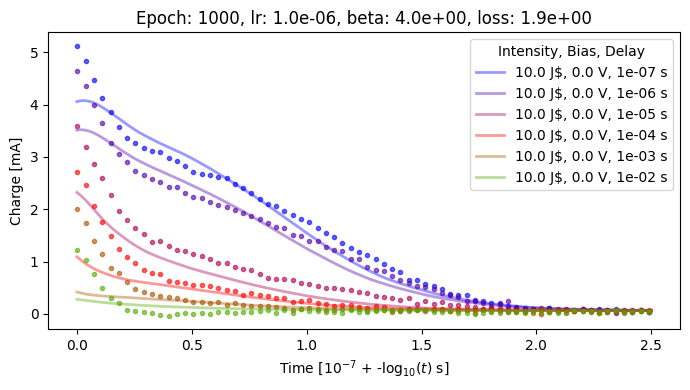

In [15]:
# Run model inference and visualisation along different parameters

# select models to plot ('intensity', 'voltage', or 'delay')
plot_models = ipynb_utils.get_sweep_index(0, 'delay')  # Example: sweep based on intensity from the first index

parameters.model_params['plot'] = plot_models
visualisation.display_random_fit(parameters.model_params, parameters.dataset, show=True, save=False, random_samples=False)


Sweep latent dimensions

In [ ]:
for dim_idx in range(model_params['latent_dim']):
    print(f"---Visualising Latent Dimension {dim_idx}---")
    visualisation.sweep_latent_adaptive(parameters.model_params, parameters.dataset, dim_idx, save=False, show=True)

---Visualising Latent Dimension 0---


KeyboardInterrupt: 

---Visualising Time-Evolved Latent Dimension 0---


Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


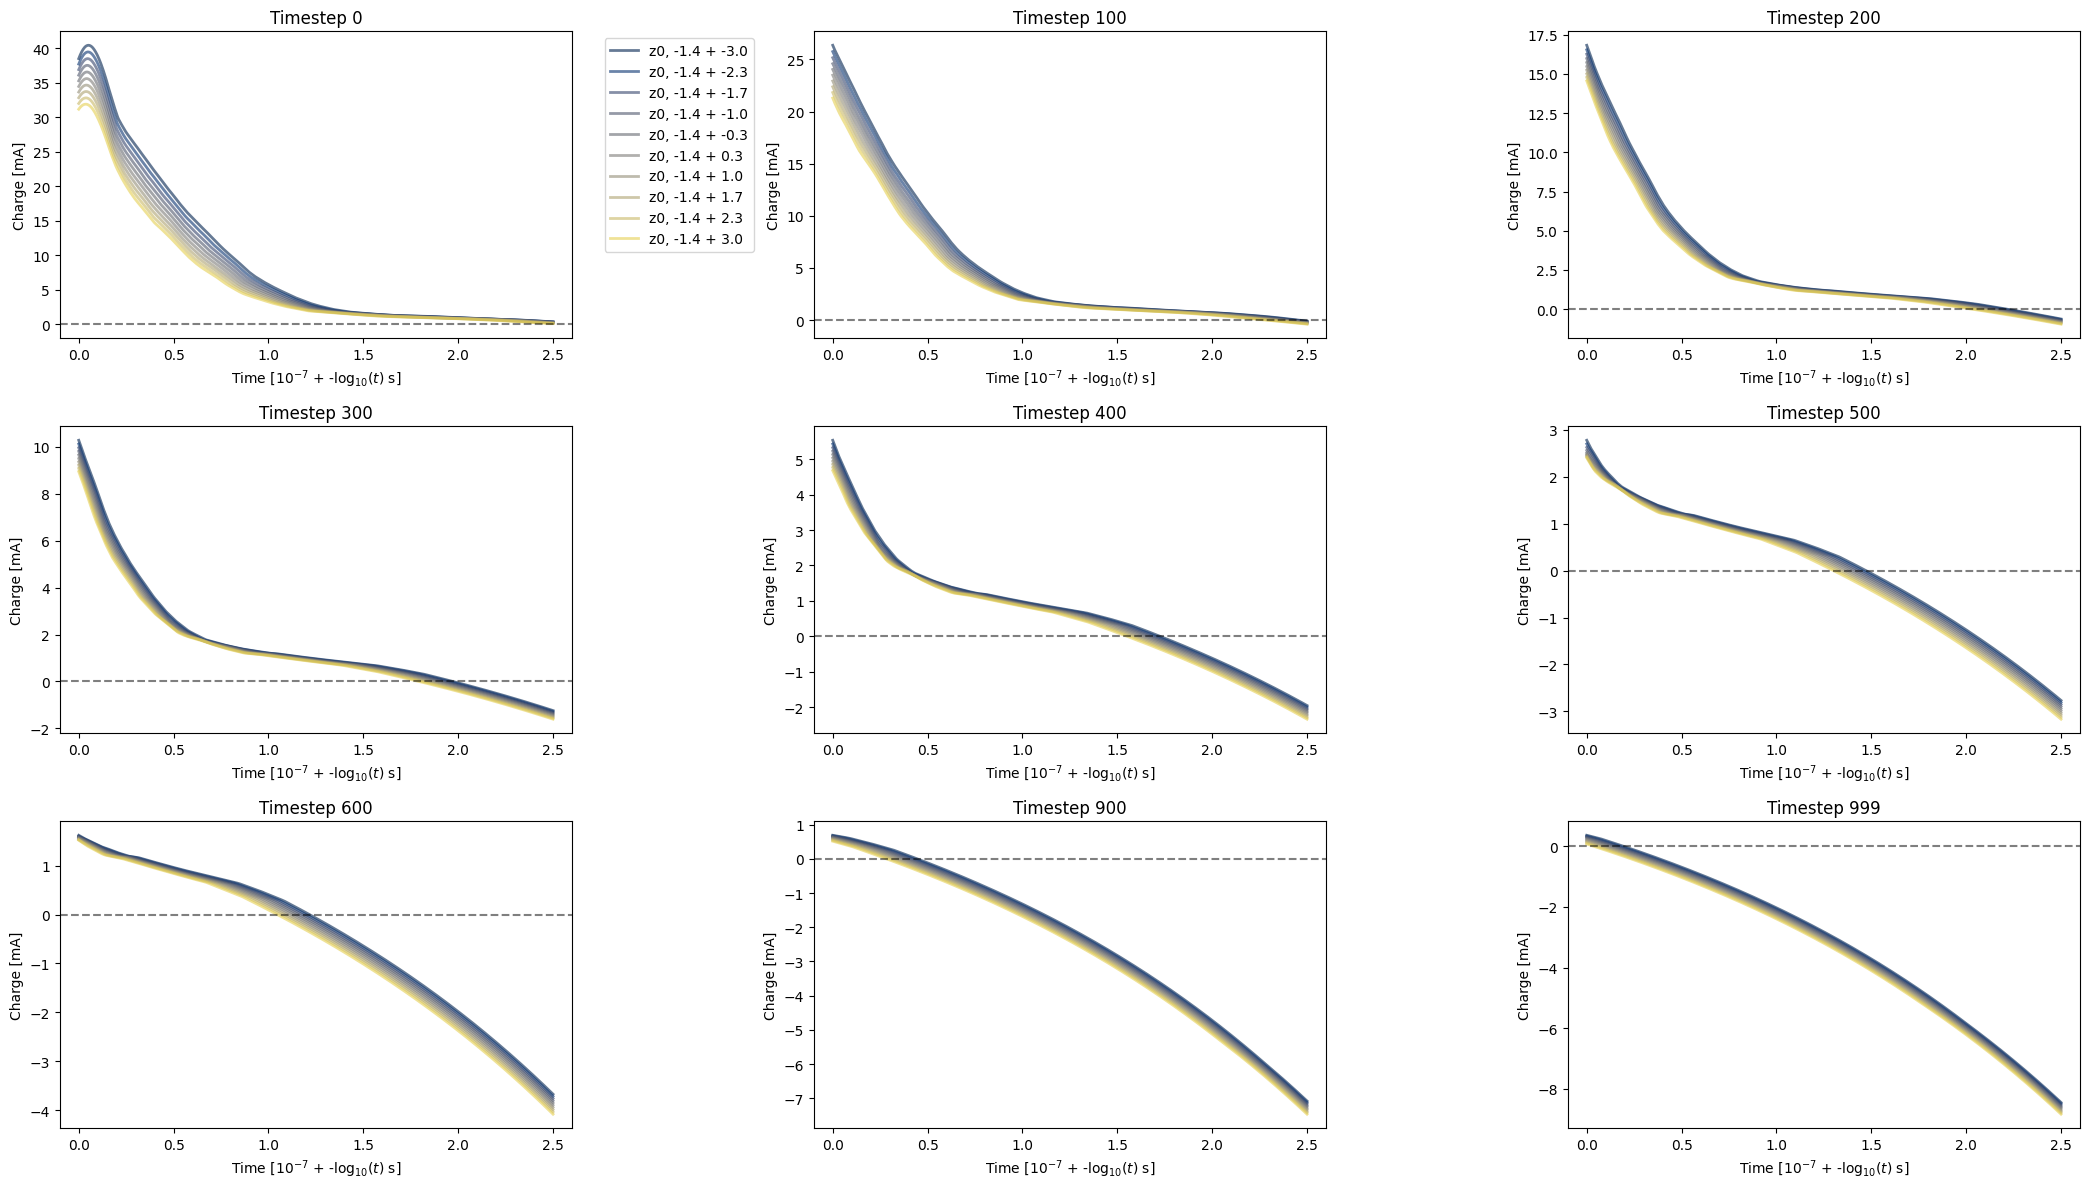

In [16]:
# Test the time evolved sweep function
dim_idx = 0  # Example latent dimension
timesteps_of_interest = [0, 100, 200, 300, 400, 500, 600, 900, 999]  # Example timesteps to analyze (0 - 999)

print(f"---Visualising Time-Evolved Latent Dimension {dim_idx}---")
visualisation.time_evolved_sweep(
    parameters.model_params, 
    parameters.dataset, 
    dim_idx, 
    timesteps_of_interest, 
    save=False, 
    show=True
)

Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


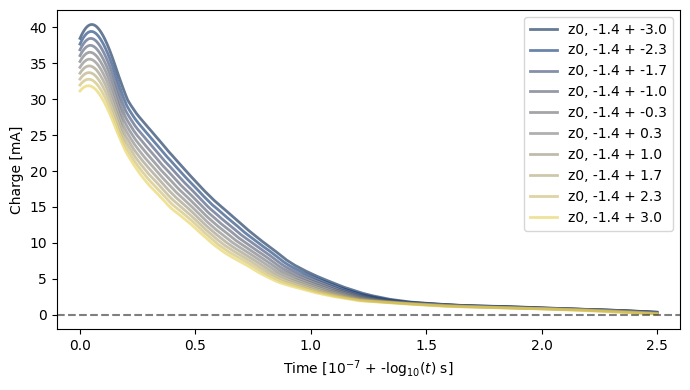

In [19]:
visualisation.sweep_latent_adaptive(parameters.model_params, parameters.dataset, 0, save=False, show=True)


UMAP Encoding of the latent space.


In [4]:
latent, all = ipynb_utils.get_latent_vectors(model_params, parameters.dataset, traj_idx=None)

Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


c:\vscode\python\TOR-2024\ML_charge_modeling\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


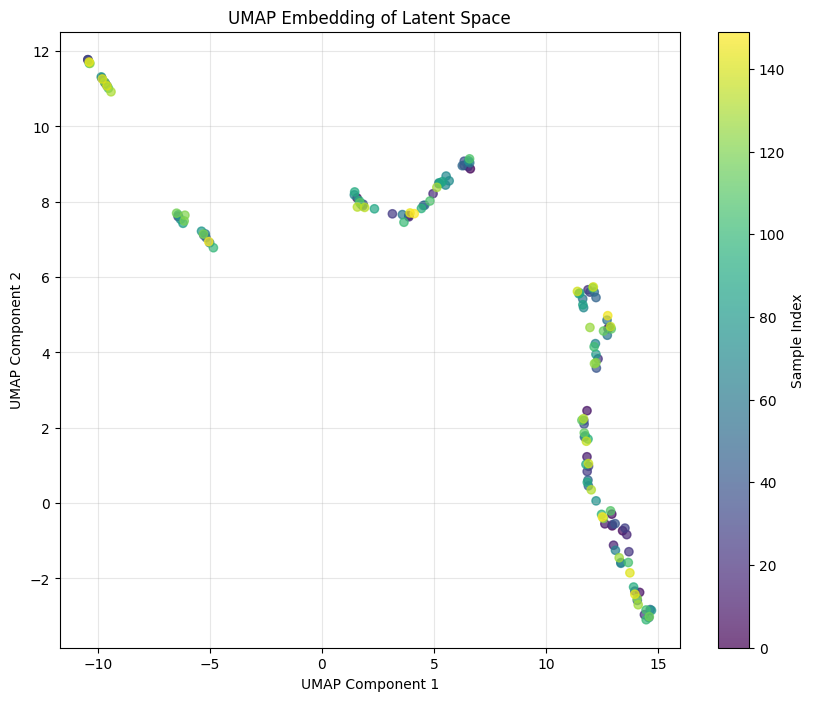

Original latent space shape: (150, 16)
UMAP embedding shape: (150, 2)


In [23]:
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler

# Standardize the latent vectors
scaler = StandardScaler()
latent_scaled = scaler.fit_transform(latent)

# Apply UMAP dimensionality reduction
reducer = UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(latent_scaled)

# Visualize the UMAP embedding
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=range(len(embedding)), cmap='viridis', alpha=0.7)
plt.colorbar(label='Sample Index')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Embedding of Latent Space')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Original latent space shape: {latent.shape}")
print(f"UMAP embedding shape: {embedding.shape}")